# Projet GouvImmo, partie 5: Modèle de régression finale

### Introduction:

Ce notebook à pour but d'effectuer un modèle de régression, dans le cadre du projet fil rouge "GouvImmo" chez Datascientest. 

### Jeu de données:

Les données ont été préalablement importés, fusionnées puis triées dans les notebook nommés gouvimmo_project_part1, gouvimmo_project_part2 et gouvimmo_project_part3 et sauvegardés dans un fichier csv nommé IDF_2019_to_2021_v3.csv

Le dataframe comporte les données de ventes immobilières de la région Ile de France, de 2019 à 2021. Il comporte des variables relatives à la localisation du bien, au type de bien vendu, à sa valeur et à ses carractéristiques (surface, nombre de pièces, nombre de dépendances, ...). 

Le but du modèle de régression est de déterminer la variable cible "Valeur foncière".

# Importation des librairies et du fichier de données en csv:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
pd.pandas.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression

In [54]:
df=pd.read_csv("IDF_2019_to_2021_v3.csv")
df.head()

,id_mutation,valeur_fonciere,date_mutation,numero_disposition,nature_mutation,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,id_parcelle,nombre_lots,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,Appartement,Dépendance,Maison,terrains_a_batir,terrains_autre,prix_m²,section_cadastrale,prix_m²_moy_ca,prix_m²_moy_co,annee,code_annee,type_bien
0,2019-1135463,310000.0,2019-01-03,1.0,Vente,11.0,NaN,RUE DE LA FONTAINE,0650,77220.0,77215,Gretz-Armainvilliers,77,772150000B0473,0,101.0,4.0,855.0,2.740574,48.739669,0,0,1,0,1,3069.31,772150000B,3646.883495,3474.511880,2019,0,Maison
1,2019-1135466,155000.0,2019-01-04,1.0,Vente,4.0,NaN,AV DE LA GARE,0600,77340.0,77373,Pontault-Combault,77,77373000AD0157,2,51.0,2.0,0.0,2.616840,48.805639,1,1,0,0,0,3039.22,77373000AD,3804.018010,3759.720085,2019,0,Appartement
2,2019-1135467,165500.0,2019-01-09,1.0,Vente,45.0,NaN,RUE LOUIS VICTOR DE BROGLIE,1413,77176.0,77445,Savigny-le-Temple,77,77445000YA0444,3,64.0,3.0,12.0,2.565832,48.605740,1,2,0,0,0,2585.94,77445000YA,2821.665116,2610.471778,2019,0,Appartement
3,2019-1135468,269000.0,2019-01-02,1.0,Vente,6.0,NaN,RUE JEAN FERRAT,0492,77310.0,77407,Saint-Fargeau-Ponthierry,77,77407000AY0353,0,84.0,4.0,270.0,2.553743,48.530118,0,0,1,0,2,3202.38,77407000AY,2815.332174,2679.428891,2019,0,Maison
4,2019-1135469,199500.0,2019-01-08,1.0,Vente,3.0,NaN,RUE DE LA PICARDIE,0186,77720.0,77211,Grandpuits-Bailly-Carrois,77,772110170D0147,0,109.0,5.0,1036.0,2.993174,48.576719,0,0,1,0,2,1830.28,772110170D,2360.692500,2020.605714,2019,0,Maison


# Preprocessing:

On commence par analyser la répartition des prix au m² selon la localisation:

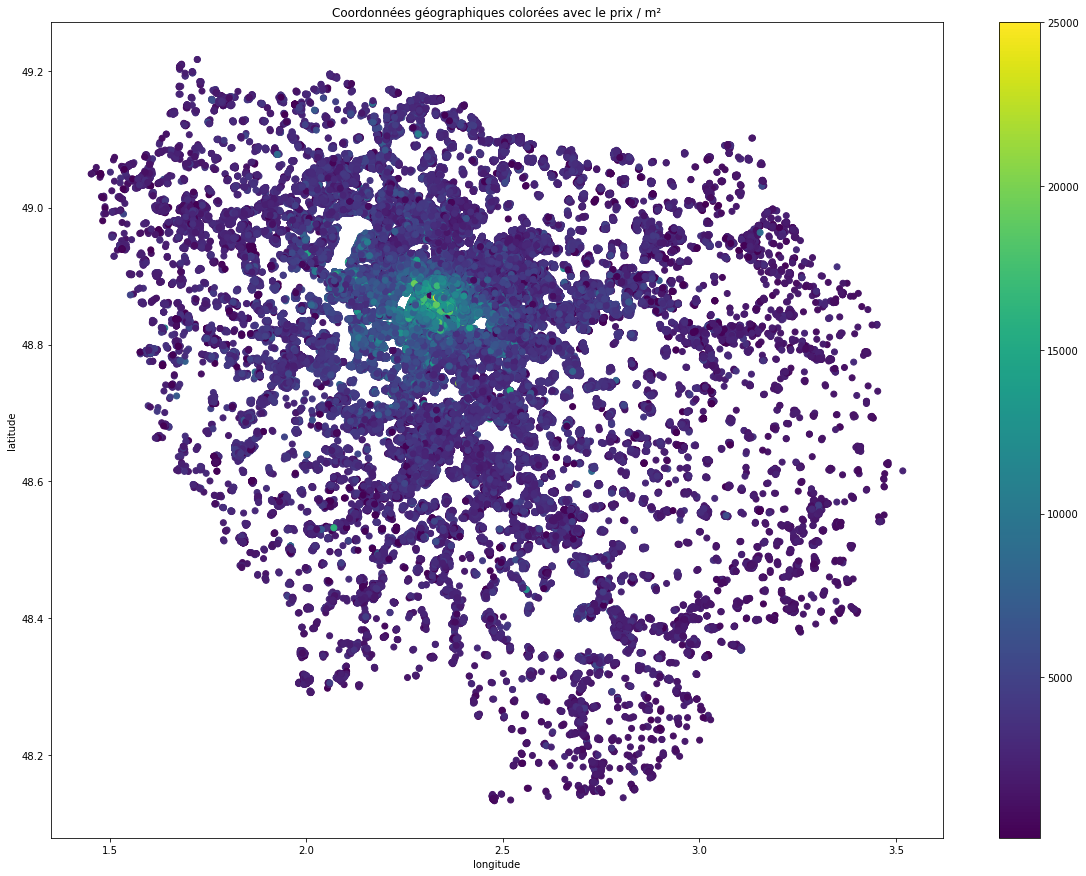

In [4]:
#Répartition des ventes, colorées selon le prix / m², dans la région Ile de France:
plt.figure( figsize= (20, 15) )
plt.scatter(df["longitude"], df["latitude"], c=df["prix_m²"])
plt.title("Coordonnées géographiques colorées avec le prix / m²")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.colorbar();

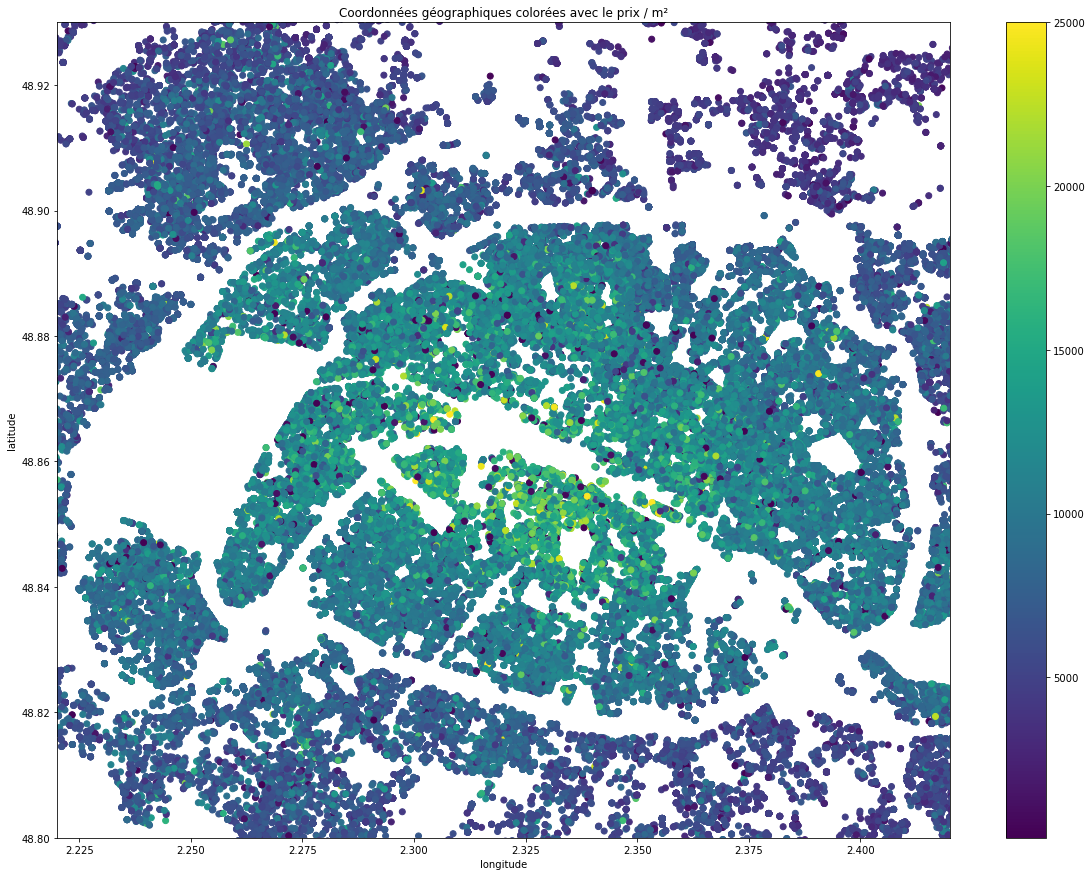

In [7]:
#Répartition des ventes, colorées selon le prix / m², zoom sur Paris:
plt.figure( figsize= (20, 15) )
plt.scatter(df["longitude"], df["latitude"], c=df["prix_m²"])
plt.title("Coordonnées géographiques colorées avec le prix / m²")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.xlim(2.22, 2.42)
plt.ylim(48.8, 48.93)
plt.colorbar();

On remarque que le centre de Paris compte les prix / m² les plus élevés, et que ceux ci semblent redescendre à mesure qu'on s'éloigne de ce centre. Pour aider le modèle de régression, on pourrait donc déterminer la position du point centrale, ou les prix / m² sont les plus hauts, et ajouter une variable distance par rapport à ce point centrale. 

La position exacte de ce point centrale est difficile à déterminer avec précision, mais il semble que l'hotel matignon soit un point ou les prix sont très élevés sur la carte. Les coordonées géographiques de ce point sont 48.854167 N ; 2.320833 E. Nous utiliserons ces coordonnées par la suite pour la création de notre variable.

### Préparation des données pour le modèle de régression:

Nous allons commencer par retirer les variables de prix au m² du dataset. En effet, variables ont été créées à partire de la variable cible, et ne doivent donc pas êtres inclues dans le modèle de régression. Nous retirerons également les variables non numériques, qui ne peuvent pas êtres utilisées par le modèle. 

Les premiers essais effectués avec le modèle Lasso avaient démontrés que la dichotomisation des codes départements permettaient d'améliorer le score du modèle. Ils ont également montré que les variables "numero_disposition", "adresse_numero", "annee", "code_annee" n'étaient pas retenues comme pertinentes par le modèle Lasso. Nous allons donc les retirer. La variable code postal est également redondante avec le code commune, nous la retirons également. Enfin, nous appliquerons une standardisation des données. 

In [55]:
#Sélection des variables numériques de df pour le modèle de régression:
num_df=df.select_dtypes(include=['int','float', "uint8"]).dropna(axis = 0, how = 'any')

#Retrait des variables prix/m² et des variables avec les coefs les plus bas retenus par Lasso:
num_df=num_df.drop(["prix_m²_moy_ca",
                    "prix_m²_moy_co",
                    "prix_m²",
                    "numero_disposition",
                    "adresse_numero",
                    "code_annee", 
                    "annee", 
                    "code_postal"], axis=1)

#Séparation de la variable cible:
target =num_df["valeur_fonciere"]
data =num_df.drop("valeur_fonciere", axis=1)

#Dichotomisation du code département:
data=data.join(pd.get_dummies(data['code_departement'], prefix='dep')).drop("code_departement", axis=1)

#Création des ensembles d'entrainement et de test:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=256)

#Standardisation des variables:
scaler = StandardScaler()
X_train=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Modèle de régression

Dans ce notebook, nous allons tester un nouveau modèle de régression en utilisant GradientBoostingRegressor. Nous tenterons les approches suivantes:

- Ajout d'une variable distance au centre
- Sélection de variables pertinentes avec SelectKBest 
- Entrainement séparé sur les données de chaque département
- Entrainement séparé sur les données par tranches de prix de 1 000 000€
- Dichotomisation des codes commune et réduction de dimentions avec ACP
- Recherche de meilleurs hyper paramètres avec GridSearchCV

Pour calculer la performances de nos modèles, nous allons définir une fonction qui renverra le score R², la MAE et la RMSE.

In [56]:
#Fonction de métriques du modèle:

def perf(model, X_train, X_test, y_train, y_test):
    pred_train =model.predict(X_train)
    pred_test = model.predict(X_test)

    print("Score train: ", model.score(X_train, y_train))
    print("Score test: ", model.score(X_test, y_test))
    print("\n")
    print("MAE train: ", mean_absolute_error(y_train, pred_train))
    print("MAE test: ", mean_absolute_error(y_test, pred_test))
    print("\n")
    print("RMSE train: ", np.sqrt(mean_squared_error(y_train, pred_train)))
    print("RMSE test: ", np.sqrt(mean_squared_error(y_test, pred_test))) 

### Test sur les données de base:

In [27]:
GBR_base=GradientBoostingRegressor()

GBR_base.fit(X_train, y_train)
perf(GBR_base, X_train, X_test, y_train, y_test)

Score train:  0.7891312589079758
Score test:  0.7863860536585858


MAE train:  77240.79018757136
MAE test:  77131.07359119834


RMSE train:  134328.0986545679
RMSE test:  134599.218241139


Nous utiliserons ces métriques comme données comparatives pour les essais d'optimisation que nous ferons par la suite.

### Ajout d'une variable distance au centre

Comme vu précédemment, nous allons créer une variable qui calculera la distance euclidienne en Km par raport au point de coordonnées 48.854167 N ; 2.320833 E, pour chaque ventes. La formule mathématique est la suivante (avec lat1, lon1: les coordonnées du premier point et lat2, lon2: les coordonnées du second point):

ACOS(SIN(RADIANS(lat1))*SIN(RADIANS(lat2))+COS(RADIANS(lat1))*COS(RA DIANS(lat2))*COS(RADIANS(lon1-lon1)))*6371

In [57]:
#Coordonnées du point centrale:
latC=48.854167
lonC=2.320833

#Création de la variable:
num_df["distance_centre"]=np.arccos(np.sin(np.radians(num_df["latitude"]))*np.sin(np.radians(latC))+np.cos(np.radians(num_df["latitude"]))*np.cos(np.radians(latC))*np.cos(np.radians(num_df["longitude"]-lonC)))*6371

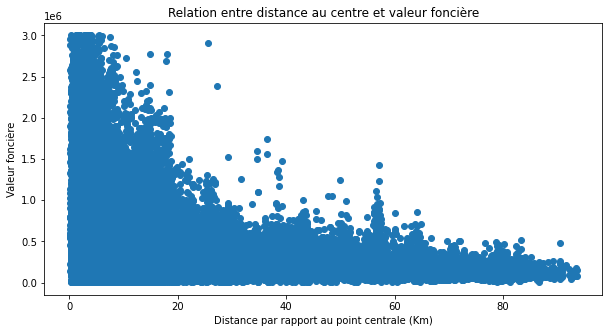

In [58]:
#Relation entre cette nouvelle variable et la variable cible:
plt.figure( figsize= (10, 5) )
plt.scatter(num_df["distance_centre"], num_df["valeur_fonciere"])
plt.title("Relation entre distance au centre et valeur foncière")
plt.xlabel("Distance par rapport au point centrale (Km)")
plt.ylabel("Valeur foncière");

La valeur foncière semble effectivement se réduire avec la distance. Nous allons vérifier si cette variable améliore notre modèle.

In [60]:
#Séparation de la variable cible:
target =num_df["valeur_fonciere"]
data =num_df.drop("valeur_fonciere", axis=1)

#Dichotomisation du code département:
data=data.join(pd.get_dummies(data['code_departement'], prefix='dep')).drop("code_departement", axis=1)

#Création des ensembles d'entrainement et de test:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=256)

#Standardisation des variables:
scaler = StandardScaler()
X_train=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [61]:
GBR_base.fit(X_train, y_train)
perf(GBR_base, X_train, X_test, y_train, y_test)

Score train:  0.8090184481552434
Score test:  0.8050331110135212


MAE train:  72335.84543540138
MAE test:  72594.60737896826


RMSE train:  127836.97161805912
RMSE test:  128590.28733813344


Cette nouvelle variable améliore notre score d'environs 2%, et fais baisser la MAE d'environs 5000€. Nous allons donc conserver cette variable. Les métriques ci-dessus deviendrons nos nouvelles métriques de référence.

### Utilisation de SelectKBest :

Nous ferons un essai en ne conservant que les 18 meilleurs variables.

In [62]:
sk=SelectKBest(f_regression, k=18)
sk.fit(data, target)
tokeep=pd.DataFrame(data=sk.get_support(), index=data.columns)
tokeep

,0
code_commune,True
nombre_lots,True
surface_reelle_bati,True
nombre_pieces_principales,True
surface_terrain,True
longitude,True
latitude,True
Appartement,True
Dépendance,True
Maison,True


In [63]:
#Retrait des variables non sélectionnées par Kbest:
Toremove=tokeep[tokeep[0]==False].index
X_trainKbest=X_train.drop(Toremove, axis=1)
X_testKbest=X_test.drop(Toremove, axis=1)

In [64]:
#Test de régression sur les données sélectionnées:
GBR=GradientBoostingRegressor()
GBR.fit(X_trainKbest, y_train)
perf(GBR, X_trainKbest, X_testKbest, y_train, y_test)

Score train:  0.8076545029158715
Score test:  0.8032681163390052


MAE train:  72702.76608682313
MAE test:  73010.99903516454


RMSE train:  128292.6502417273
RMSE test:  129171.02652775972


La sélection de données avec SelectKBest ne semble pas donner d'amélioration du modèle. Ce ne sera donc pas retenu. 

### Test par départements:

Nous allons repartire de notre df et le séparer en 8 dataframes pour chaque départements, avant de réexécuter les opérations de prétraitement.

In [65]:
df_75=num_df[num_df["code_departement"]==75].drop("code_departement", axis=1)
df_77=num_df[num_df["code_departement"]==77].drop("code_departement", axis=1)
df_78=num_df[num_df["code_departement"]==78].drop("code_departement", axis=1)
df_91=num_df[num_df["code_departement"]==91].drop("code_departement", axis=1)
df_92=num_df[num_df["code_departement"]==92].drop("code_departement", axis=1)
df_93=num_df[num_df["code_departement"]==93].drop("code_departement", axis=1)
df_94=num_df[num_df["code_departement"]==94].drop("code_departement", axis=1)
df_95=num_df[num_df["code_departement"]==95].drop("code_departement", axis=1)

In [66]:
def pretraitement(df):
    #Séparation de la variable cible:
    targetdep =df["valeur_fonciere"]
    datadep =df.drop("valeur_fonciere", axis=1)

    #Création des ensembles d'entrainement et de test:
    X_traindep, X_testdep, y_traindep, y_testdep = train_test_split(datadep, targetdep, test_size=0.3, random_state=256)

    #Standardisation des variables:
    X_traindep=pd.DataFrame(scaler.fit_transform(X_traindep), columns=X_traindep.columns)
    X_testdep=pd.DataFrame(scaler.transform(X_testdep), columns=X_testdep.columns)
    
    return X_traindep, X_testdep, y_traindep, y_testdep

In [67]:
dataframes=[df_75, df_77, df_78, df_91, df_92, df_93, df_94, df_95]
departements=["75", "77", "78", "91", "92", "93", "94", "95"]

for dep, dataframe in zip(departements, dataframes):
    X_traindep, X_testdep, y_traindep, y_testdep=pretraitement(dataframe)
    GBR.fit(X_traindep, y_traindep)
    print("Scores pour département"+dep)
    print(perf(GBR, X_traindep, X_testdep, y_traindep, y_testdep))
    print("----------------------------------")


Scores pour département75
Score train:  0.823718371599873
Score test:  0.8115623697179485


MAE train:  100511.37405763827
MAE test:  102127.86322045562


RMSE train:  182940.0420928211
RMSE test:  188819.09073685613
None
----------------------------------
Scores pour département77
Score train:  0.7180309478698054
Score test:  0.6832843772161576


MAE train:  36786.03545587124
MAE test:  38027.44824420086


RMSE train:  55348.33197090898
RMSE test:  59121.00283142958
None
----------------------------------
Scores pour département78
Score train:  0.8129451497364572
Score test:  0.7916389313600936


MAE train:  61134.72405020086
MAE test:  62140.17298113878


RMSE train:  97983.19176767029
RMSE test:  101798.37010891167
None
----------------------------------
Scores pour département91
Score train:  0.7793812840138883
Score test:  0.7365589174841772


MAE train:  37865.10347482236
MAE test:  38939.37779688578


RMSE train:  57444.526363706034
RMSE test:  64736.93544396068
None
-----------

Les scores individuels pour chaque départements ne sont pas améliorés de façon significative, ou sont moins bons que le score de référence. Cette solution ne sera pas retenue.

### Test par tranches de prix:

Nous allons repartire de notre df et le séparer en 3 dataframes pour les tranches de prix 0 - 1M, 1M - 2M, 2M - 3M, avant de réexécuter les opérations de prétraitement.

In [68]:
df_1M=num_df[num_df["valeur_fonciere"]<1000000]
df_2M=num_df[(num_df["valeur_fonciere"]>1000000)&(num_df["valeur_fonciere"]<2000000)]
df_3M=num_df[num_df["valeur_fonciere"]>2000000]

In [70]:
def pretraitement2(df):
    #Séparation de la variable cible:
    targetprix =df["valeur_fonciere"]
    dataprix =df.drop("valeur_fonciere", axis=1)
    
    #Dichotomisation du code département:
    dataprix=dataprix.join(pd.get_dummies(dataprix['code_departement'], prefix='dep')).drop("code_departement", axis=1)

    #Création des ensembles d'entrainement et de test:
    X_trainprix, X_testprix, y_trainprix, y_testprix = train_test_split(dataprix, targetprix, test_size=0.3, random_state=256)

    #Standardisation des variables:
    X_trainprix=pd.DataFrame(scaler.fit_transform(X_trainprix), columns=X_trainprix.columns)
    X_testprix=pd.DataFrame(scaler.transform(X_testprix), columns=X_testprix.columns)
    
    return X_trainprix, X_testprix, y_trainprix, y_testprix

In [71]:
dataframes=[df_1M, df_2M, df_3M]
tranches=["moins de 1M", "Entre 1M et 2M", "Plus de 2M"]

for tranche, dataframe in zip(tranches, dataframes):
    X_trainprix, X_testprix, y_trainprix, y_testprix=pretraitement2(dataframe)
    GBR.fit(X_trainprix, y_trainprix)
    print("Scores pour tranche de prix "+tranche)
    print(perf(GBR, X_trainprix, X_testprix, y_trainprix, y_testprix))
    print("----------------------------------")

Scores pour tranche de prix moins de 1M
Score train:  0.7476585467732975
Score test:  0.7427495883051818


MAE train:  61187.05181602038
MAE test:  61612.62338199357


RMSE train:  92413.0730923468
RMSE test:  93251.45869889304
None
----------------------------------
Scores pour tranche de prix Entre 1M et 2M
Score train:  0.4834849841869997
Score test:  0.4359384598998667


MAE train:  140102.2431687911
MAE test:  147886.51285811642


RMSE train:  179605.13921567795
RMSE test:  189295.21947217733
None
----------------------------------
Scores pour tranche de prix Plus de 2M
Score train:  0.47568546520023025
Score test:  0.1490902642348786


MAE train:  158944.26021212694
MAE test:  215111.25214747037


RMSE train:  196983.02057946048
RMSE test:  259341.92911060087
None
----------------------------------


Les scores par tranche de prix ne sont pas meilleures que le score de référence. De plus, on remarque que les métriques pour les prix inférieures à 1 000 000€ restent proches de celles du modèle de base, mais deviennent largement moins bonnes pour des prix de plus de 1 000 000€. On pourrait en déduire que le modèle a beaucoup de mal à évaluer des prix au dela de cette somme. 

### Test avec ACP sur les données de code commune dichotomisées:

In [72]:
#Dimentions des données du département 77:
print("Nombre de lignes pour le département 77: ", num_df.loc[num_df["code_departement"]==77].shape[0])

#Nombre de communes dans le 77:
print("Nombre de communes pour le département 77: ", len(num_df.loc[num_df["code_departement"]==77, "code_commune"].unique()))

Nombre de lignes pour le département 77:  41586
Nombre de communes pour le département 77:  500


Pour améliorer la performance du modèle vis a vis des données de localisation, nous pouvons tenter de dichotomiser les codes commune. Cependant, leur nombre étant de plus de 1200, cette opération donnerait un jeu de données trop important. Nous pourrions alors tenter de le réduire par le biais d'une analyse en composantes principales PCA. 

Dans un soucil de réduction du temps de calcul, nous allons tester notre hypothèse sur les données du département du 77 uniquement. Ce département comporte 500 communes, et compte 41586 lignes dans notre dataframe. Il compte donc un nombre suffisemment élevé de commune pour justifier l'utilisation d'une PCA, et les performances du modèle sur ces données pourront être comparrées à celles obtenues précédemment lors du test par départements.

In [73]:
#Séparation de la variable cible:
target2 =num_df.loc[num_df["code_departement"]==77, "valeur_fonciere"]
data2 =num_df.loc[num_df["code_departement"]==77].drop(["valeur_fonciere", "code_departement"], axis=1)

#Dichotomisation du code commune:
data2=data2.join(pd.get_dummies(data2['code_commune'], prefix='com')).drop(["code_commune"], axis=1)

#Création des ensembles d'entrainement et de test:
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, target2, test_size=0.3, random_state=256)

#Standardisation des variables:
X_train2=pd.DataFrame(scaler.fit_transform(X_train2), columns=X_train2.columns)
X_test2=pd.DataFrame(scaler.transform(X_test2), columns=X_test2.columns)

Nous testons d'abord le modèle avant PCA:

In [74]:
#Modèle GBR sur le dataset avec dichotomisation communes:
GBR_base.fit(X_train2, y_train2)
perf(GBR_base, X_train2, X_test2, y_train2, y_test2)

Score train:  0.7436625414990983
Score test:  0.6923041457613188


MAE train:  35961.30064800125
MAE test:  37385.68070124291


RMSE train:  52772.76531293007
RMSE test:  58273.06632309837


Les performances sont légèrement meilleurs que lors du test sur ce même département avant dichotomisation du code commune. Nous allons vérifier si une PCA permettrait d'améliorer ce score:

In [76]:
#Instanciation d'un PCA:
pca=PCA()
X_train2_PCA =pca.fit_transform(X_train2)
X_test2_PCA =pca.fit_transform(X_test2)

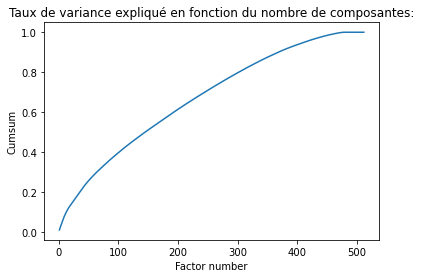

In [77]:
#Taux de variance expliqué en fonctioin du nombre de composantes:
plt.plot(np.arange(1, pca.explained_variance_.shape[0]+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Factor number')
plt.ylabel('Cumsum')
plt.title("Taux de variance expliqué en fonction du nombre de composantes:");

In [78]:
#Nombre de composantes permettant de conserver au moins 90% de la variance expliqué:
len(np.cumsum(pca.explained_variance_ratio_)[np.cumsum(pca.explained_variance_ratio_)<0.95])

411

La courbe de variance expliqué en fonction du nombre de composantes n'est pas très avantageuse: Elle est quasi linéaire. Pour conserver au moins 90% de la variance expliqué, il nous faut conserver 411 composantes sur les 512 initiales, ce qui reste très élevé.

In [79]:
#Sélection des 411 premières composantes:
X_train2_PCA=X_train2_PCA[:, :411]
X_test2_PCA=X_test2_PCA[:, :411]

In [80]:
#Modèle GBR sur le dataset avec dichotomisation communes + pca:
GBR_base.fit(X_train2_PCA, y_train2)
perf(GBR_base, X_train2_PCA, X_test2_PCA, y_train2, y_test2)

Score train:  0.7133802072024339
Score test:  -0.7772181475564406


MAE train:  38694.700518494006
MAE test:  109146.17904912333


RMSE train:  55802.91728878645
RMSE test:  140048.1636030349


L'application d'une ACP rends le modèle totalement inutilisable sur les données de test. Cela ne sera donc pas retenu.

### Test avec les données traitées avec PolynomialFeatures:

Il a été démontré dans le précédent notebook qu'un traitement des données avec PolynomialFeatures améliorait les performances du modèle. Nous allons tenter un traitement avec PolynomialFeatures d'ordre 2 pour voir si cela permet d'améliorer notre modèle.

In [84]:
#Traitement polynomial:
poly=PolynomialFeatures(2)
X_train_poly=poly.fit_transform(X_train)
X_test_poly=poly.transform(X_test)

GBR_base.fit(X_train_poly, y_train)
perf(GBR_base, X_train_poly, X_test_poly, y_train, y_test)

Score train:  0.8158621681806661
Score test:  0.8104647291566633


MAE train:  71072.01601150361
MAE test:  71427.44772990995


RMSE train:  125525.59178401681
RMSE test:  126786.42492028963


Le traitement polynomial n'améliore pas significativement la performance du modèle. Cette solution ne sera pas retenue.

### Recherche de meilleurs hyper paramètres:

Les test effectués par départements, tranche de prix, ou avec utilisation d'ACP n'ont pas donné de résultats concluants. Nous resterons donc sur notre modèle de base. Nous allons tenter de l'optimiser en faisant une recherche de meilleurs hyper paramètres. Nous allons notemment jouer sur n_estimators et max_depth.

In [85]:
parametres={"n_estimators":[50,200,300], "max_depth":[2, 4, 5]}

grid_clf = GridSearchCV(estimator=GBR_base, param_grid=parametres)
grille = grid_clf.fit(X_train, y_train)
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score', 'std_test_score']])

                                  params  mean_test_score  std_test_score
0   {'max_depth': 2, 'n_estimators': 50}         0.743222        0.002493
1  {'max_depth': 2, 'n_estimators': 200}         0.795187        0.003356
2  {'max_depth': 2, 'n_estimators': 300}         0.802382        0.003441
3   {'max_depth': 4, 'n_estimators': 50}         0.804751        0.003934
4  {'max_depth': 4, 'n_estimators': 200}         0.830082        0.004136
5  {'max_depth': 4, 'n_estimators': 300}         0.834362        0.004004
6   {'max_depth': 5, 'n_estimators': 50}         0.818573        0.003973
7  {'max_depth': 5, 'n_estimators': 200}         0.836834        0.003883
8  {'max_depth': 5, 'n_estimators': 300}         0.840351        0.004063


Les meilleurs paramètres sont 'max_depth': 5, 'n_estimators': 300. Nous allons réentrainer notre modèle avec ces paramètres.

In [86]:
GBR_final=GradientBoostingRegressor(n_estimators=300, max_depth=5)

GBR_final.fit(X_train, y_train)
perf(GBR_final, X_train, X_test, y_train, y_test)

Score train:  0.865730104688226
Score test:  0.8373974480023565


MAE train:  60709.85739154074
MAE test:  62851.30149793714


RMSE train:  107188.96811879585
RMSE test:  117433.34038617778


Les résultats du modèle sont meilleurs que ceux du modèle de base, néanmoins, nous notons un score sur l'ensemble de test inférieur d'environ 3% au score de l'ensemble d'entrainement, témoignant d'un léger overfitting. 

# Analyse détaillée des performances du modèle:

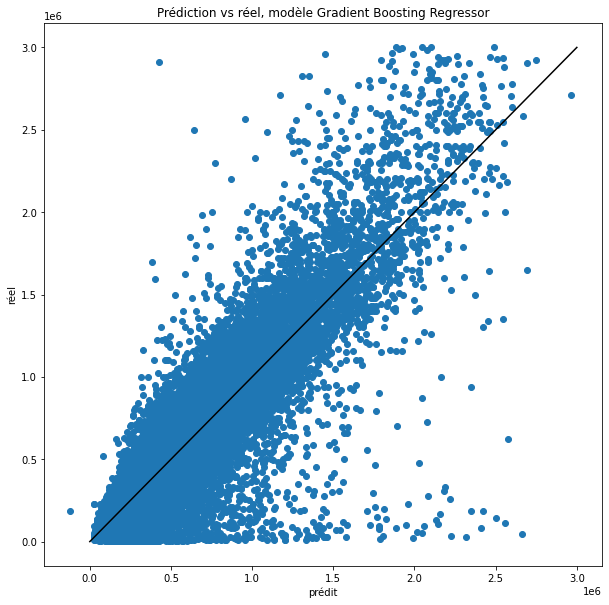

In [87]:
#Prédiction vs réel:
pred_test = GBR_final.predict(X_test)
plt.figure( figsize= (10, 10) )
plt.scatter(pred_test, y_test)
plt.plot([0, 3000000], [0, 3000000], c="black")
plt.xlabel("prédit")
plt.ylabel("réel")
plt.title("Prédiction vs réel, modèle Gradient Boosting Regressor");

Les prédictions semblent globalement s'aligner sur le réel, mais avec une forte dispersion. 

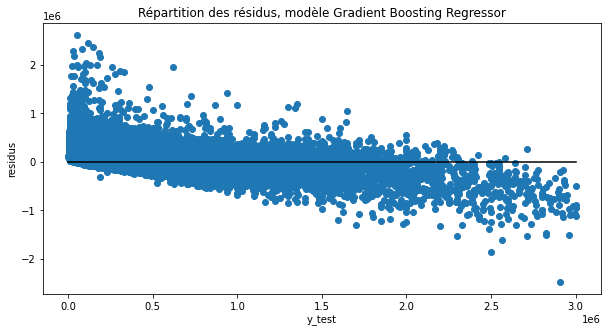

In [88]:
residus=pred_test-y_test
plt.figure( figsize= (10, 5) )
plt.scatter(y_test, residus)
plt.plot([0, max(y_test)], [0, 0], c="black")
plt.xlabel("y_test")
plt.ylabel("residus")
plt.title("Répartition des résidus, modèle Gradient Boosting Regressor");

La répartition des résidus révèle une tendance à surestimer les prix les plus bas et à sous estimer les prix les plus élevés. 

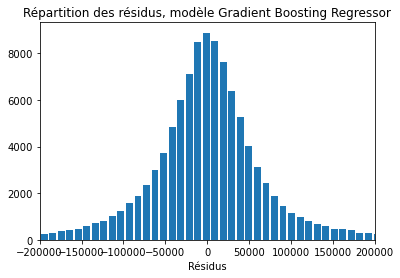

In [89]:
plt.hist(residus, bins=500, rwidth=0.8)
plt.xlim(-200000, 200000)
plt.title("Répartition des résidus, modèle Gradient Boosting Regressor")
plt.xlabel("Résidus");

Les résidus sont globalement centrés sur 0, avec la majorité des résidus compris entre plus ou moins 100 000€

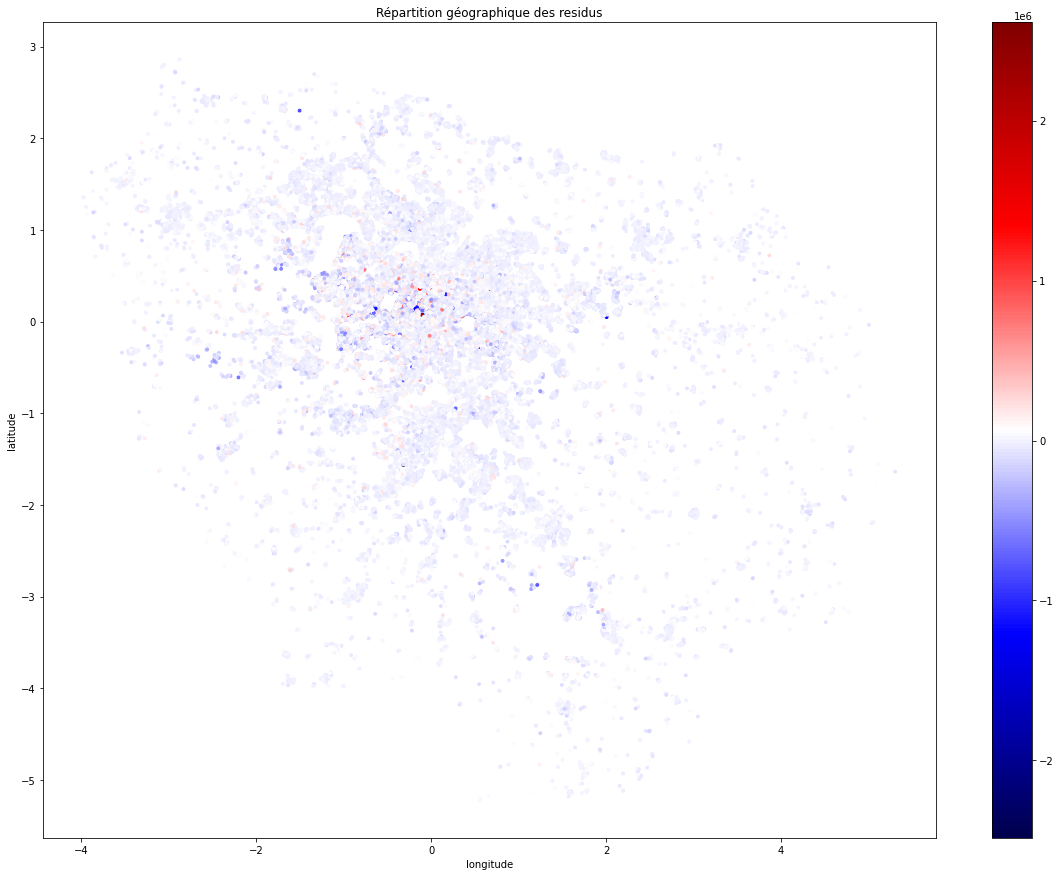

In [90]:
plt.figure( figsize= (20, 15) )
plt.scatter(X_test["longitude"], X_test["latitude"], c=residus, cmap="seismic", s=8)
plt.title("Répartition géographique des residus")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.colorbar();

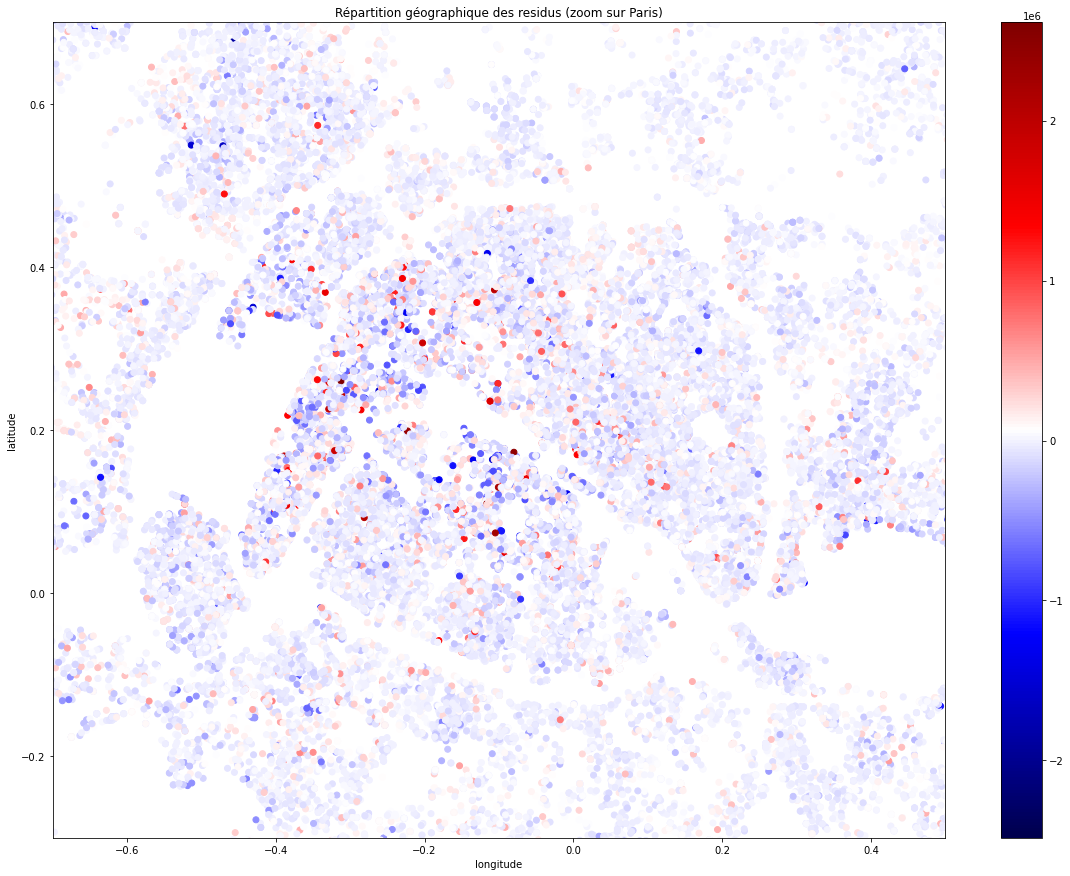

In [91]:
plt.figure( figsize= (20, 15) )
plt.scatter(X_test["longitude"], X_test["latitude"], c=residus, cmap="seismic")
plt.title("Répartition géographique des residus (zoom sur Paris)")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.xlim(-0.7, 0.5)
plt.ylim(-0.3, 0.7)
plt.colorbar();

On remarque sur ces graphiques que les résidus les plus élevés se concentrent dans la zone de Paris. Sur le reste de la région, les résidus semblent plus proche de 0. 

# Conclusions:

Nous avons réussi à obtenir un modèle de régression permettant d'obtenir une estimation de prix avec une précision d'environ 84% et une erreur moyenne absolue d'environ 63 000€ sur des prix de vente jusqu'à 3 000 000€. Cependant, notre modèle semble plus efficace sur des estimations de prix entre 500 000€ et 1 000 000€. Nous pourrions donc restreindre l'utilisation de ce modèle à cette tranche de prix.

Nous notons également que notre modèle prend encore mal en compte l'impact de la localisation, en sur-estimant les prix bas et en sous-estimant les prix élevés. Les ventes dans la zone de Paris étant globalement plus élevées que dans le reste de la région, le modèle se trouve peu performant dans cette zone précise.

Enfin, le manque de variables explicatives dans notre jeu de données sur les caractéristiques des biens vendus comme le nombre de chambres, de salles de bain ou encore la vétusté du bien explique probablement en partie la forte dispertion des résidus.

Des solutions envisageables pour améliorer le modèle, notamment dans sa prise en compte de la notion de localisation, pourraient être d'utiliser des algorithmes de régression pondérées géographiquement (GWR). Cette solution ne sera néanmoins pas testée dans ce projet par manque de temps.